# Import

In [1]:
# Basic
import pandas as pd
import numpy as np
import warnings

warnings.simplefilter('ignore')

# ML Toolkit
from robusta.selector import *
from robusta.crossval import *
from robusta.pipeline import *
from robusta.preprocessing import *

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.metrics import *

# Model
from sklearn.linear_model import Ridge

# Plot
from jupyterthemes import jtplot
import matplotlib.pyplot as plt
import matplotlib

jtplot.style('gruvboxd')
matplotlib.use('nbagg')

Using TensorFlow backend.


# Data

In [2]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

X, y = make_regression(n_samples=200, n_features=50, n_informative=5, 
                       random_state=666)

X = pd.DataFrame(X)
y = pd.Series(y)

X.rename(columns=lambda x: 'x{}'.format(x), inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Task & Model

In [3]:
get_score = lambda y_true, y_pred: -mean_squared_error(y_true, y_pred)
scoring = 'neg_mean_squared_error'

cv = 5

model = Ridge()

# Baseline

In [4]:
features = X_train.columns

_, y_pred = crossval_predict(model, cv, X_train[features], y_train, X_new=X_test[features],
                             scoring=scoring, verbose=2, n_jobs=None)

get_score(y_test, y_pred)

[23:07:36]  Ridge

[23:07:36]  FOLD  0:   -4.4332
[23:07:36]  FOLD  1:   -13.3185
[23:07:36]  FOLD  2:   -5.2113
[23:07:36]  FOLD  3:   -19.5226
[23:07:36]  FOLD  4:   -12.6811

[23:07:36]  AVERAGE:   -11.0333 ± 5.6118



-11.124871666693128

# Differential Evolution

In [30]:
from robusta.selector.base import _AgnosticSelector, FeatureSubset
from sklearn.utils.random import check_random_state
from deap import creator, base, tools, algorithms


def cxSubset(ind1, ind2, indpb=0.5, random_state=None):
    
    rstate = check_random_state(random_state)
    mask1, mask2 = [], []
    
    for x, y in zip(ind1.mask, ind2.mask):
        if rstate.rand() < indpb:
            mask1.append(x)
            mask2.append(y)
        else:
            mask1.append(y)
            mask2.append(x)
            
    child1 = ind1.copy().set_mask(mask1)
    child2 = ind2.copy().set_mask(mask2)
    
    child1.parents = (ind1, ind2)
    child2.parents = (ind1, ind2)
    
    return child1, child2


def mutSubset(ind, indpb, random_state=None):
    
    rstate = check_random_state(random_state)
    mask = []
    
    for x in ind.mask:
        y = (rstate.rand() < indpb)
        mask.append(x ^ y)
    
    return ind.set_mask(mask)


class GeneticSelector(_AgnosticSelector):
    
    def __init__(self, estimator, cv=5, scoring=None, mut_prob=0.1, mut_rate=0.05, 
                 crossover=0.7, pop_size=50, max_time=None, max_iter=None, std=-0.1, 
                 random_state=None, n_jobs=None, verbose=1, n_digits=4):

        self.estimator = estimator
        self.scoring = scoring
        self.std = std
        self.cv = cv
        
        self.crossover = crossover
        self.mut_prob = mut_prob
        self.mut_rate = mut_rate
        self.pop_size = pop_size
        self.max_iter = max_iter
        self.max_time = max_time
        
        self.random_state = random_state
        self.n_jobs = n_jobs
        
        self.verbose = verbose
        self.n_digits = n_digits
    
    
    def fit(self, X, y):

        self._fit_start(X)
        self._fit(X, y)

        return self
    
    
    def partial_fit(self, X, y):

        self._fit_start(X, partial=True)
        self._fit(X, y)

        return self
    
    
    def _mask_to_subset(self, mask):
        return self.features_[mask]
    
    
    def _fit_start(self, X, partial=False):

        self._set_features(X)
        
        if not partial or not hasattr(self, 'trials_'):
            
            self._reset_trials()

            # Init toolbox
            self.toolbox = base.Toolbox()
            self.rstate = check_random_state(self.random_state)
            
            # Define individual
            self.toolbox.register("individual", self.features_.sample)
            
            # Define population
            self.toolbox.register("population", tools.initRepeat, 
                                  list, self.toolbox.individual)
            self.population = self.toolbox.population(n=self.pop_size)
        
        return self
            
        
    def _fit(self, X, y):
        
        # Define mutation & selection
        self.toolbox.register("eval", self._eval_subset, X=X, y=y)
        self.toolbox.register("mate", cxSubset, random_state=self.rstate)
        self.toolbox.register("mutate", mutSubset, random_state=self.rstate, 
                              indpb=self.mut_rate)
        self.toolbox.register("select", tools.selTournament, tournsize=3, 
                              fit_attr='score')
        
        while not self.max_iter or self.n_iters_ < self.max_iter:
            try:
                # Select the next generation individuals
                offspring = [ind.copy() for ind in self.population]
                
                # Apply crossover
                for i in range(1, len(offspring), 2):
                    if self.rstate.rand() < self.crossover:
                        parent1, parent2 = offspring[i-1], offspring[i]
                        child1, child2 = self.toolbox.mate(parent1, parent2)
                        # FIXME:
                        if hasattr(child1, 'score'):
                            del child1.score, child1.score_std
                        if hasattr(child2, 'score'):
                            del child2.score, child2.score_std
                        offspring[i-1], offspring[i] = child1, child2
                
                # Apply mutation
                for mutant in offspring:
                    if self.rstate.rand() < self.mut_prob:
                        self.toolbox.mutate(mutant)
                        # FIXME:
                        if hasattr(mutant, 'score'):
                            del mutant.score, mutant.score_std
                
                # Evaluate
                for ind in offspring:
                    if not hasattr(ind, 'score') and len(ind):
                        self.toolbox.eval(ind)
                    
                # Select
                self.population = self.toolbox.select(offspring, k=self.pop_size)
            
            except KeyboardInterrupt:
                break
                
        return self
    
    
    def get_features(self):
        return self._mask_to_subset(tools.selBest(self.population, k=1)[0])
    
    
    def _get_features(self, X):
        return X.columns.values

In [32]:
selector = GeneticSelector(model, cv, scoring)
selector.fit(X_train, y_train)

[04:15:19] ITER: 1      SUBSET: 26/50      SCORE: -2180.8469 ± 377.9471
[04:15:19] ITER: 2      SUBSET: 23/50      SCORE: -14653.5034 ± 4264.2374
[04:15:19] ITER: 3      SUBSET: 30/50      SCORE: -25034.2551 ± 4849.5360
[04:15:19] ITER: 4      SUBSET: 22/50      SCORE: -17508.2590 ± 3794.5847
[04:15:19] ITER: 5      SUBSET: 28/50      SCORE: -18753.6499 ± 7745.2178
[04:15:19] ITER: 6      SUBSET: 25/50      SCORE: -17044.1863 ± 1847.6876
[04:15:19] ITER: 7      SUBSET: 27/50      SCORE: -6623.0756 ± 1730.2100
[04:15:19] ITER: 8      SUBSET: 21/50      SCORE: -20336.3594 ± 6578.0833
[04:15:19] ITER: 9      SUBSET: 24/50      SCORE: -19487.3802 ± 4598.4052
[04:15:19] ITER: 10      SUBSET: 29/50      SCORE: -22510.9435 ± 7197.5990
[04:15:19] ITER: 11      SUBSET: 20/50      SCORE: -13217.8643 ± 3151.5865
[04:15:19] ITER: 12      SUBSET: 28/50      SCORE: -4362.3285 ± 992.7885
[04:15:19] ITER: 13      SUBSET: 23/50      SCORE: -21459.6576 ± 6336.6474
[04:15:19] ITER: 14      SUBSET: 33/50 

[04:15:22] ITER: 117      SUBSET: 27/50      SCORE: -4.5317 ± 1.1241
[04:15:22] ITER: 118      SUBSET: 23/50      SCORE: -5944.8557 ± 1490.7812
[04:15:22] ITER: 119      SUBSET: 30/50      SCORE: -6456.5182 ± 743.9268
[04:15:22] ITER: 120      SUBSET: 26/50      SCORE: -4.3639 ± 1.8776
[04:15:22] ITER: 121      SUBSET: 29/50      SCORE: -4802.6185 ± 553.5218
[04:15:23] ITER: 122      SUBSET: 33/50      SCORE: -5.0272 ± 1.6407
[04:15:23] ITER: 123      SUBSET: 25/50      SCORE: -2054.2950 ± 351.7774
[04:15:23] ITER: 124      SUBSET: 25/50      SCORE: -2255.1705 ± 218.0893
[04:15:23] ITER: 125      SUBSET: 27/50      SCORE: -2102.2914 ± 314.7203
[04:15:23] ITER: 126      SUBSET: 24/50      SCORE: -5545.5404 ± 381.1072
[04:15:23] ITER: 127      SUBSET: 25/50      SCORE: -4.3282 ± 1.6150
[04:15:23] ITER: 128      SUBSET: 28/50      SCORE: -1910.1739 ± 243.4827
[04:15:23] ITER: 129      SUBSET: 30/50      SCORE: -4.6252 ± 1.9054
[04:15:23] ITER: 130      SUBSET: 22/50      SCORE: -7690.6964

[04:15:27] ITER: 236      SUBSET: 21/50      SCORE: -3.7101 ± 0.9498
[04:15:27] ITER: 237      SUBSET: 18/50      SCORE: -10135.3792 ± 2663.2816
[04:15:27] ITER: 238      SUBSET: 27/50      SCORE: -4.2934 ± 1.0967
[04:15:27] ITER: 239      SUBSET: 23/50      SCORE: -4.2360 ± 2.4446
[04:15:27] ITER: 240      SUBSET: 25/50      SCORE: -3.8353 ± 1.0834
[04:15:27] ITER: 241      SUBSET: 24/50      SCORE: -4.1324 ± 1.2496
[04:15:27] ITER: 242      SUBSET: 25/50      SCORE: -4.0098 ± 0.8366
[04:15:27] ITER: 243      SUBSET: 26/50      SCORE: -3.9683 ± 1.3517
[04:15:27] ITER: 244      SUBSET: 25/50      SCORE: -3.9730 ± 1.2060
[04:15:27] ITER: 245      SUBSET: 22/50      SCORE: -3.7834 ± 1.3774
[04:15:27] ITER: 246      SUBSET: 22/50      SCORE: -3.8349 ± 1.4623
[04:15:27] ITER: 247      SUBSET: 28/50      SCORE: -4.8526 ± 1.5301
[04:15:27] ITER: 248      SUBSET: 26/50      SCORE: -4.3807 ± 1.9674
[04:15:27] ITER: 249      SUBSET: 21/50      SCORE: -3.5704 ± 1.0486
[04:15:27] ITER: 250      S

[04:15:31] ITER: 360      SUBSET: 20/50      SCORE: -3.2947 ± 1.0539
[04:15:31] ITER: 361      SUBSET: 18/50      SCORE: -3.1020 ± 0.9117
[04:15:31] ITER: 362      SUBSET: 18/50      SCORE: -3.2984 ± 1.2890
[04:15:31] ITER: 363      SUBSET: 21/50      SCORE: -3.4242 ± 1.2883
[04:15:31] ITER: 364      SUBSET: 17/50      SCORE: -3.0848 ± 0.8500
[04:15:31] ITER: 365      SUBSET: 22/50      SCORE: -3.5030 ± 1.0434
[04:15:31] ITER: 366      SUBSET: 17/50      SCORE: -3.0809 ± 0.9291
[04:15:31] ITER: 367      SUBSET: 19/50      SCORE: -3.3732 ± 1.1461
[04:15:31] ITER: 368      SUBSET: 18/50      SCORE: -3.1330 ± 1.0733
[04:15:31] ITER: 369      SUBSET: 20/50      SCORE: -3.3050 ± 1.0664
[04:15:31] ITER: 370      SUBSET: 21/50      SCORE: -3.3969 ± 1.1473
[04:15:31] ITER: 371      SUBSET: 20/50      SCORE: -3.2639 ± 0.7705
[04:15:31] ITER: 372      SUBSET: 21/50      SCORE: -3.4097 ± 0.9464
[04:15:31] ITER: 373      SUBSET: 21/50      SCORE: -3.4097 ± 0.9464
[04:15:31] ITER: 374      SUBSET: 

[04:15:35] ITER: 479      SUBSET: 19/50      SCORE: -3.0576 ± 0.6298
[04:15:35] ITER: 480      SUBSET: 16/50      SCORE: -2.9439 ± 0.7487
[04:15:35] ITER: 481      SUBSET: 15/50      SCORE: -2.9451 ± 0.9154
[04:15:35] ITER: 482      SUBSET: 17/50      SCORE: -3.0464 ± 0.9735
[04:15:35] ITER: 483      SUBSET: 16/50      SCORE: -3.0218 ± 1.0495
[04:15:35] ITER: 484      SUBSET: 13/50      SCORE: -2.7765 ± 0.7986
[04:15:35] ITER: 485      SUBSET: 16/50      SCORE: -2.8631 ± 0.5584
[04:15:35] ITER: 486      SUBSET: 16/50      SCORE: -2.8995 ± 0.8292
[04:15:35] ITER: 487      SUBSET: 17/50      SCORE: -3.0818 ± 1.0852
[04:15:35] ITER: 488      SUBSET: 18/50      SCORE: -3.1668 ± 0.8157
[04:15:35] ITER: 489      SUBSET: 14/50      SCORE: -2.7941 ± 0.6902
[04:15:35] ITER: 490      SUBSET: 16/50      SCORE: -3.0156 ± 0.5120
[04:15:35] ITER: 491      SUBSET: 15/50      SCORE: -2.9723 ± 0.9450
[04:15:35] ITER: 492      SUBSET: 16/50      SCORE: -2.9827 ± 0.6414
[04:15:35] ITER: 493      SUBSET: 

[04:15:38] ITER: 597      SUBSET: 13/50      SCORE: -2.7720 ± 0.6001
[04:15:38] ITER: 598      SUBSET: 13/50      SCORE: -2.6886 ± 0.5510
[04:15:38] ITER: 599      SUBSET: 13/50      SCORE: -2.7100 ± 0.5816
[04:15:38] ITER: 600      SUBSET: 12/50      SCORE: -2.6630 ± 0.5377
[04:15:38] ITER: 601      SUBSET: 14/50      SCORE: -2.7671 ± 0.6079
[04:15:38] ITER: 602      SUBSET: 12/50      SCORE: -2.6207 ± 0.5815
[04:15:39] ITER: 603      SUBSET: 14/50      SCORE: -2.7400 ± 0.5981
[04:15:39] ITER: 604      SUBSET: 15/50      SCORE: -3.2582 ± 0.9447
[04:15:39] ITER: 605      SUBSET: 12/50      SCORE: -2.6614 ± 0.4717
[04:15:39] ITER: 606      SUBSET: 12/50      SCORE: -2.6577 ± 0.6368
[04:15:39] ITER: 607      SUBSET: 12/50      SCORE: -2.6577 ± 0.6368
[04:15:39] ITER: 608      SUBSET: 12/50      SCORE: -2.6630 ± 0.5377
[04:15:39] ITER: 609      SUBSET: 12/50      SCORE: -2.6630 ± 0.5377
[04:15:39] ITER: 610      SUBSET: 11/50      SCORE: -2.5984 ± 0.5716
[04:15:39] ITER: 611      SUBSET: 

[04:15:42] ITER: 719      SUBSET: 15/50      SCORE: -2.9722 ± 0.8047
[04:15:42] ITER: 720      SUBSET: 12/50      SCORE: -2.6284 ± 0.5113
[04:15:42] ITER: 721      SUBSET: 12/50      SCORE: -2.6534 ± 0.6135
[04:15:43] ITER: 722      SUBSET: 11/50      SCORE: -2.5984 ± 0.5716
[04:15:43] ITER: 723      SUBSET: 11/50      SCORE: -2.6063 ± 0.6144
[04:15:43] ITER: 724      SUBSET: 13/50      SCORE: -2.6591 ± 0.5846
[04:15:43] ITER: 725      SUBSET: 10/50      SCORE: -2.5446 ± 0.5430
[04:15:43] ITER: 726      SUBSET: 11/50      SCORE: -2.5984 ± 0.5716
[04:15:43] ITER: 727      SUBSET: 10/50      SCORE: -2.5409 ± 0.5208
[04:15:43] ITER: 728      SUBSET: 11/50      SCORE: -2.5826 ± 0.5295
[04:15:43] ITER: 729      SUBSET: 12/50      SCORE: -2.6620 ± 0.5734
[04:15:43] ITER: 730      SUBSET: 12/50      SCORE: -2.6488 ± 0.6454
[04:15:43] ITER: 731      SUBSET: 9/50      SCORE: -2.5029 ± 0.4905
[04:15:43] ITER: 732      SUBSET: 10/50      SCORE: -2.5479 ± 0.5232
[04:15:43] ITER: 733      SUBSET: 1

GeneticSelector(crossover=0.7, cv=5,
                estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                                max_iter=None, normalize=False,
                                random_state=None, solver='auto', tol=0.001),
                max_iter=None, max_time=None, mut_prob=0.1, mut_rate=0.05,
                n_digits=4, n_jobs=None, pop_size=50, random_state=None,
                scoring='neg_mean_squared_error', std=-0.1, verbose=1)

<IPython.core.display.Javascript object>


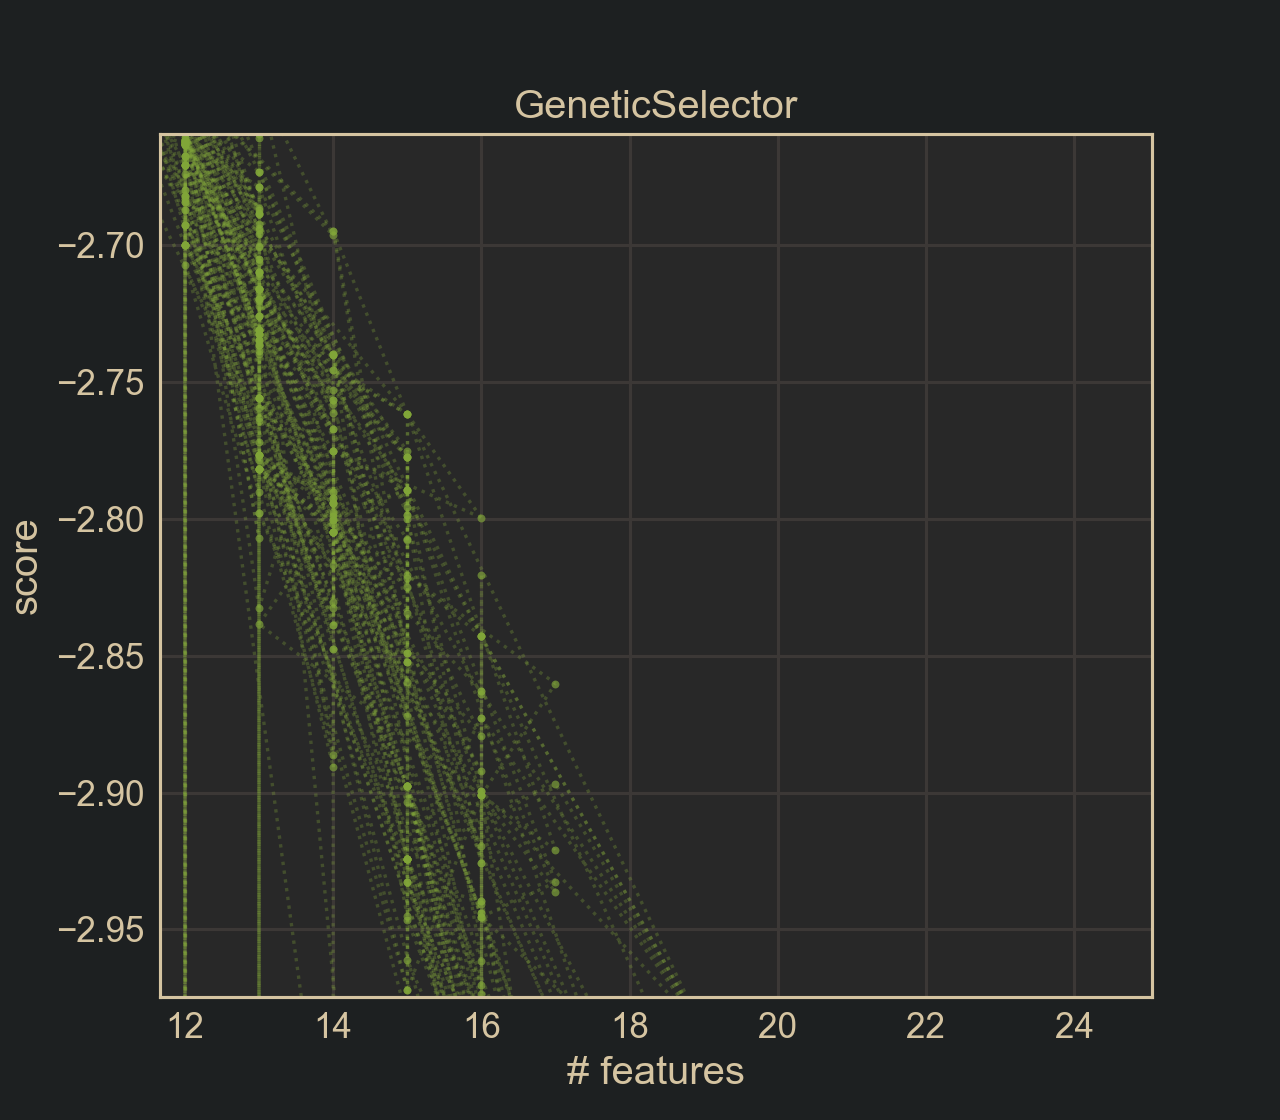

In [33]:
%matplotlib notebook

selector.plot(marker='.', color='g', linestyle=':', alpha=0.3)